In [1]:
import wandb
import datetime
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.patches import Patch

entity = "ocrl_benchmark"
project = "agent-learning"
default_tags = ["toplot", "sparserewtype", "hardmode"]

# envs
envs = [
        "targetN4C4S3S1",
        "pushN3C4S1S1",
        "oddoneoutN4C2S2S1oc",
        "oddoneoutN4C2S2S1",
]
envs = np.array(envs)

# titles
titles = [
        "Object Goal Task",
        "Object Interaction Task",
        "Object Comparison Task",
        "Property Comparison Task",
]

# colormap
cm = plt.cm.get_cmap("tab20").colors
# models
models = {
    "GT": {"tags": ["gt"]},
    "CNN": {"tags": ["cnn", "pooling-identity"]},
    "CNNFeat": {"tags": ["cnnfeat"]},
    "MultiCNNs": {"tags": ["multicnns"]},
    "VAE": {"tags": ["vae"]},
    "MAE-CLS": {"tags": ["mae-cls"]},
    "SLATE-CNN": {"tags": ["slate-cnn"]},
    "MAE-Patch": {"tags": ["mae-patch"]},
    "SLATE": {"tags": ["slate"]},
    "Slot-Attention": {"tags": ["slotattention"]},
    "Slot-Attention-Large": {"tags": ["slotattention-large"]},
    "IODINE": {"tags": ["iodine"]},
}
print(f"Models: {models.keys()}")

Models: dict_keys(['IODINE'])


In [2]:
api = wandb.Api(timeout=19)
results = {}
for model_i, model_name in enumerate(models.keys()):
    if not model_name in results.keys():
        results[model_name] = {}
    for env_i, env_name in enumerate(envs):
        if not env_name in results[model_name].keys():
            results[model_name][env_name] = {"step": [], "wall_time": [], "mean": [], "std": []}
        print(model_name, env_name)
        filters = []
        filters.append({"tags": envs[env_i]})
        for model_tag in models[model_name]["tags"]:
            filters.append({"tags": model_tag})
        for default_tag in default_tags:
            filters.append({"tags": default_tag})
            if model_name == "IODINE" and (env_name=="pushN3C4S1S1" or env_name=="oddoneoutN4C2S2S1oc"):
                runs = api.runs(f"jaesikyoon/ocrl-rl", filters={"$and": filters})
            else:
                runs = api.runs(f"{entity}/{project}", filters={"$and": filters})
            global_steps = []
            wall_times = []
            success_rates = []
            for run in runs:
                #print(run)
                history = run.scan_history(["global_step","_timestamp","eval/success_rate"])
                _global_step = []
                _wall_times = []
                _success_rate = []
                for row in history:
                    _global_step.append(row["global_step"])
                    _wall_times.append(row["_timestamp"])
                    _success_rate.append(row["eval/success_rate"])
                global_steps.append(_global_step)
                wall_times.append(_wall_times)
                success_rates.append(_success_rate)
            if len(global_steps) == 0:
                continue
            step = 2000000 // 4000 # plotting to 2000000 steps
            min_step_idx = 100
            min_step = 2000000
            # success rates
            for rate_idx in range(len(success_rates)):
                success_rates[rate_idx] = success_rates[rate_idx][:step]
                if min_step > len(success_rates[rate_idx]):
                    min_step_idx = rate_idx
                    min_step = len(success_rates[rate_idx])
            sr_steps = global_steps[min_step_idx][:min_step]
            sr_wall_times = [wall_time[:min_step] for wall_time in wall_times][-1]
            success_rates = [success_rate[:min_step] for success_rate in success_rates]
            sr_mean = np.mean(success_rates, axis=0)
            sr_std = np.std(success_rates, axis=0)
            results[model_name][env_name]["step"] = sr_steps
            results[model_name][env_name]["wall_time"] = sr_wall_times
            results[model_name][env_name]["mean"] = sr_mean
            results[model_name][env_name]["std"] = sr_std

IODINE targetN4C4S3S1
IODINE pushN3C4S1S1
IODINE oddoneoutN4C2S2S1oc
IODINE oddoneoutN4C2S2S1


In [ ]:
results
import json
with open("results/model_wise_globalstep_walltime.json", "w") as f:
    json.dump(results, f)

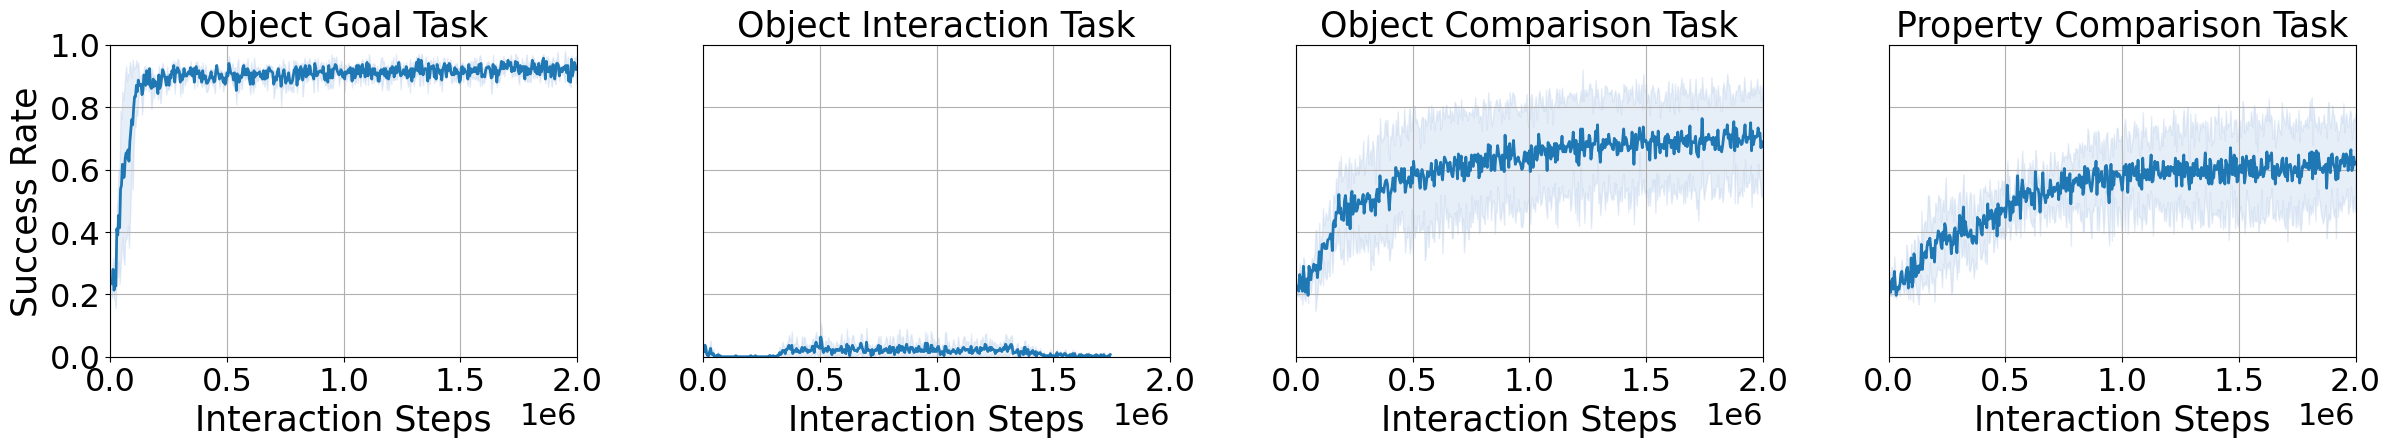

In [3]:
# colormap
cm = plt.cm.get_cmap("tab20").colors
for model_i, model_name in enumerate(models.keys()):
    # plots
    top = 0.09
    hspace = 0.07
    bottom = 0.26
    height = 1 - top - bottom
    left = 0.09
    wspace = 0.05
    right = 0.019
    width = (1 - left - right - wspace * (envs.shape[0] - 1)) / envs.shape[0]
    recs = np.zeros((1,envs.shape[0]), dtype=object)
    for i in range(recs.shape[0]):
        for j in range(recs.shape[1]):
            recs[i, j] = [
                left + j * (width + wspace),  # left
                bottom + (recs.shape[0] - 1 - i) * (height + hspace),  # bottom
                width,
                height,
            ]
    plt.figure(figsize=(6.3 * recs.shape[1], 4.8 * recs.shape[0]))
    for env_i, env_name in enumerate(envs):
        step = results[model_name][env_name]["step"] if "step" in results[model_name][env_name].keys() else []
        if "wall_time" in results[model_name][env_name].keys():
            wall_time = results[model_name][env_name]["wall_time"]
            wall_time = np.array(wall_time) / 60 / 60
            wall_time -= wall_time[0]
        else:
            wall_time = []
            continue
        sr_mean = results[model_name][env_name]["mean"] if "mean" in results[model_name][env_name].keys() else []
        sr_std = results[model_name][env_name]["std"] if "std" in results[model_name][env_name].keys() else []
        ax = plt.axes(recs[0, env_i])
        (line,) = ax.plot(
            step,
            sr_mean,
            color=cm[0],
            label=model_name,
            linewidth=2,
        )
        plt.fill_between(
            step,
            sr_mean - sr_std,
            sr_mean + sr_std,
            color=cm[1],
            alpha=0.3,
        )
        ax.grid(True)
        ax.xaxis.offsetText.set_fontsize(22)
        axes = plt.gca()
        ax.set_ylim([0.0, 1.0])
        ax.set_xlim([0.0, 2e6])
        plt.yticks(fontsize=23)
        if env_i == 0:
            ax.set_ylabel("Success Rate", fontsize=25)
        else:
            ax.yaxis.set_ticklabels([])
            ax.yaxis.set_ticks_position("none")
        plt.xticks([0, 500000, 1000000, 1500000, 2000000], fontsize=23)
        ax.set_xlabel("Interaction Steps", fontsize=25) 
        ax.set_title(titles[env_i], fontsize=25)
    plt.savefig(f"icml_{model_name}_globalstep.png")

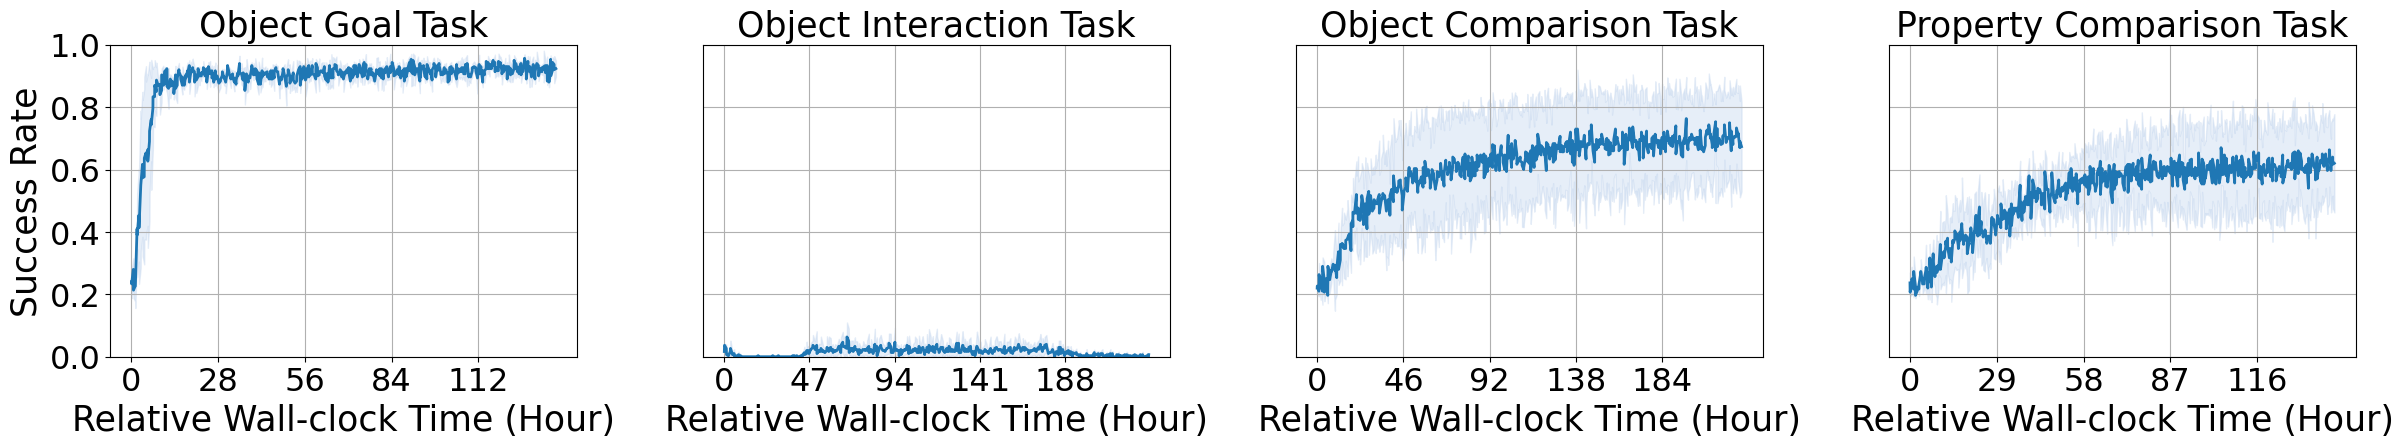

In [4]:
# colormap
cm = plt.cm.get_cmap("tab20").colors
for model_i, model_name in enumerate(models.keys()):
    # plots
    top = 0.09
    hspace = 0.07
    bottom = 0.26
    height = 1 - top - bottom
    left = 0.09
    wspace = 0.05
    right = 0.019
    width = (1 - left - right - wspace * (envs.shape[0] - 1)) / envs.shape[0]
    recs = np.zeros((1,envs.shape[0]), dtype=object)
    for i in range(recs.shape[0]):
        for j in range(recs.shape[1]):
            recs[i, j] = [
                left + j * (width + wspace),  # left
                bottom + (recs.shape[0] - 1 - i) * (height + hspace),  # bottom
                width,
                height,
            ]
    plt.figure(figsize=(6.3 * recs.shape[1], 4.8 * recs.shape[0]))
    for env_i, env_name in enumerate(envs):
        step = results[model_name][env_name]["step"] if "step" in results[model_name][env_name].keys() else []
        if len(results[model_name][env_name]["wall_time"]) == 0:
            continue
        wall_time = results[model_name][env_name]["wall_time"]
        wall_time = np.array(wall_time) / 60 / 60
        wall_time -= wall_time[0]
        sr_mean = results[model_name][env_name]["mean"] if "mean" in results[model_name][env_name].keys() else []
        sr_std = results[model_name][env_name]["std"] if "std" in results[model_name][env_name].keys() else []
        ax = plt.axes(recs[0, env_i])
        (line,) = ax.plot(
            #step,
            wall_time,
            sr_mean,
            color=cm[0],
            label=model_name,
            linewidth=2,
        )
        plt.fill_between(
            #step,
            wall_time,
            sr_mean - sr_std,
            sr_mean + sr_std,
            color=cm[1],
            alpha=0.3,
        )
        ax.grid(True)
        ax.xaxis.offsetText.set_fontsize(22)
        axes = plt.gca()
        ax.set_ylim([0.0, 1.0])
        #ax.set_xlim([0.0, 2e6])
        plt.yticks(fontsize=23)
        if env_i == 0:
            ax.set_ylabel("Success Rate", fontsize=25)
        else:
            ax.yaxis.set_ticklabels([])
            ax.yaxis.set_ticks_position("none")
        plt.xticks([int(_wall_time) for _wall_time in range(0,int(wall_time[-1])+1, int(wall_time[-1]/5)+1)], fontsize=23)
        ax.set_xlabel("Relative Wall-clock Time (Hour)", fontsize=25) 
        ax.set_title(titles[env_i], fontsize=25)
    plt.savefig(f"icml_{model_name}_walltime.png")